Exploratory Data Analysis 

In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_control_chart, plot_capability, plot_boxplot
from utilities_widgets import position_chart
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\luciano.galan\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_")[0]
default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_")[0]
fixture_data = consult_database("input.db", verbose=False, filter=file+"_fixture_data_")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits, fixture_data), description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "fixture_data" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('VA_007_fixture…

Table *VA_007_measurements_2024y_01m_09d_18h_15m_58s* retrieved succesfully.
Table *VA_007_limits_2024y_01m_09d_18h_15m_58s* retrieved succesfully.
Table *VA_007_fixture_data_2024y_01m_09d_18h_31m_28s* retrieved succesfully.


In [4]:
##Database management
print(f"File ready to add to the database:")
for table in tables.value:
    print(f"    {table}")

File ready to add to the database:
    VA_007_measurements_2024y_01m_09d_18h_15m_58s
    VA_007_limits_2024y_01m_09d_18h_15m_58s
    VA_007_fixture_data_2024y_01m_09d_18h_31m_28s


In [5]:
##Data preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
display(MEAS_format)

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,test: 11
Guia_Luz_Blanco_FB1_X,0.3287,0.3277,0.3281,0.3286,0.3322,0.3337,0.3225,0.3259,0.3255,0.3256,0.3254
Guia_Luz_Blanco_FB1_Y,0.3511,0.3500,0.3505,0.3510,0.3536,0.3546,0.3457,0.3480,0.3477,0.3482,0.3476
Guia_Luz_Blanco_FB2_X,0.3298,0.3285,0.3287,0.3293,0.3349,0.3356,0.3239,0.3260,0.3257,0.3264,0.3255
Guia_Luz_Blanco_FB2_Y,0.3521,0.3510,0.3512,0.3515,0.3558,0.3562,0.3462,0.3481,0.3479,0.3482,0.3477
Guia_Luz_Blanco_FB3_X,0.3245,0.3237,0.3239,0.3247,0.3271,0.3274,0.3213,0.3218,0.3217,0.3225,0.3216
Guia_Luz_Blanco_FB3_Y,0.3464,0.3453,0.3456,0.3463,0.3481,0.3483,0.3429,0.3433,0.3433,0.3439,0.3431
Guia_Luz_Blanco_FB4_X,0.3429,0.3261,0.3301,0.3353,0.3276,0.3286,0.3274,0.3275,0.3273,0.3274,0.3259
Guia_Luz_Blanco_FB4_Y,0.3639,0.3499,0.3532,0.3571,0.3506,0.3515,0.3505,0.3505,0.3504,0.3504,0.3494
Guia_Luz_Blanco_FB5_X,0.3474,0.3269,0.3306,0.3371,0.3269,0.3283,0.3267,0.3267,0.3270,0.3271,0.3248
Guia_Luz_Blanco_FB5_Y,0.3666,0.3497,0.3537,0.3585,0.3497,0.3510,0.3498,0.3500,0.3500,0.3500,0.3487


In [6]:
##Limits review
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("limits:")
display(LIMITS_format)

limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.310,0.335
Guia_Luz_Blanco_FB1_Y,0.325,0.358
Guia_Luz_Blanco_FB2_X,0.310,0.335
Guia_Luz_Blanco_FB2_Y,0.325,0.358
Guia_Luz_Blanco_FB3_X,0.310,0.335
Guia_Luz_Blanco_FB3_Y,0.325,0.358
Guia_Luz_Blanco_FB4_X,0.310,0.335
Guia_Luz_Blanco_FB4_Y,0.325,0.358
Guia_Luz_Blanco_FB5_X,0.310,0.335
Guia_Luz_Blanco_FB5_Y,0.325,0.358


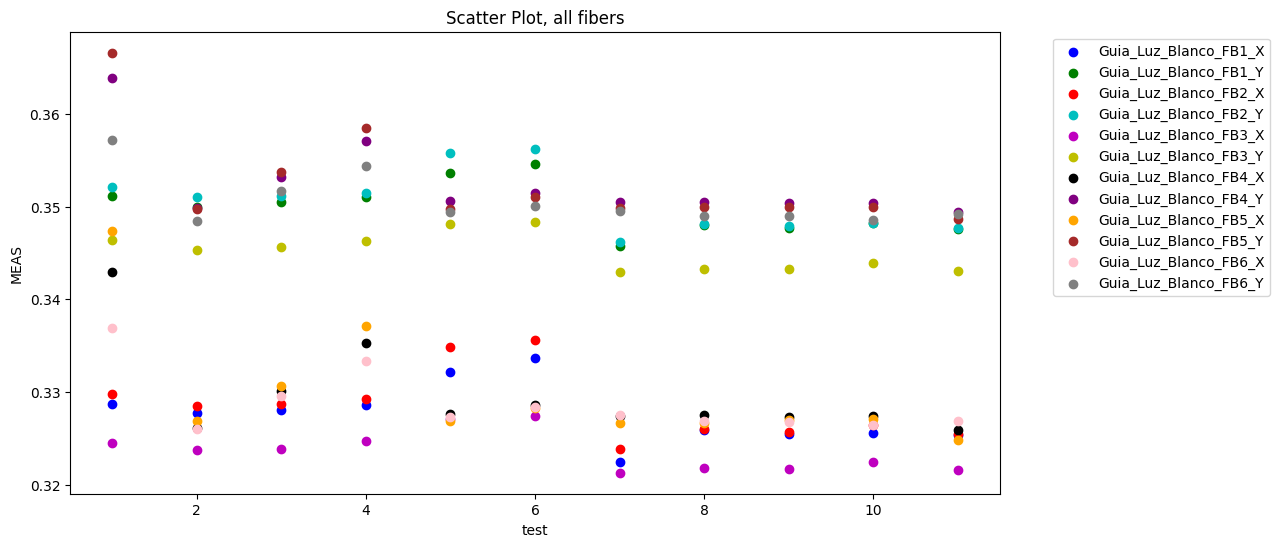

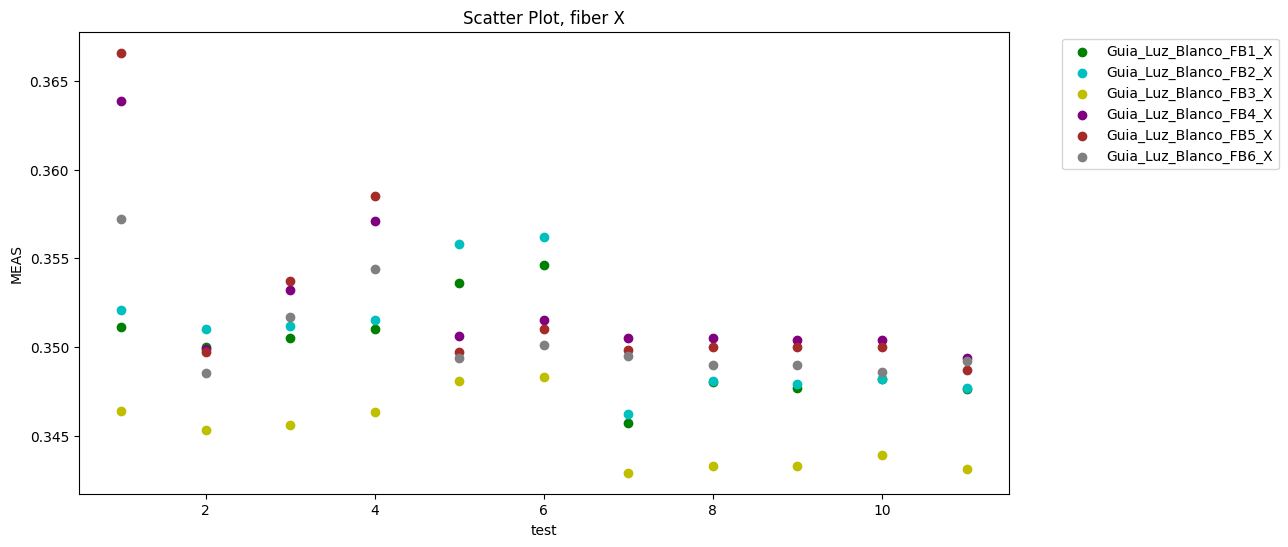

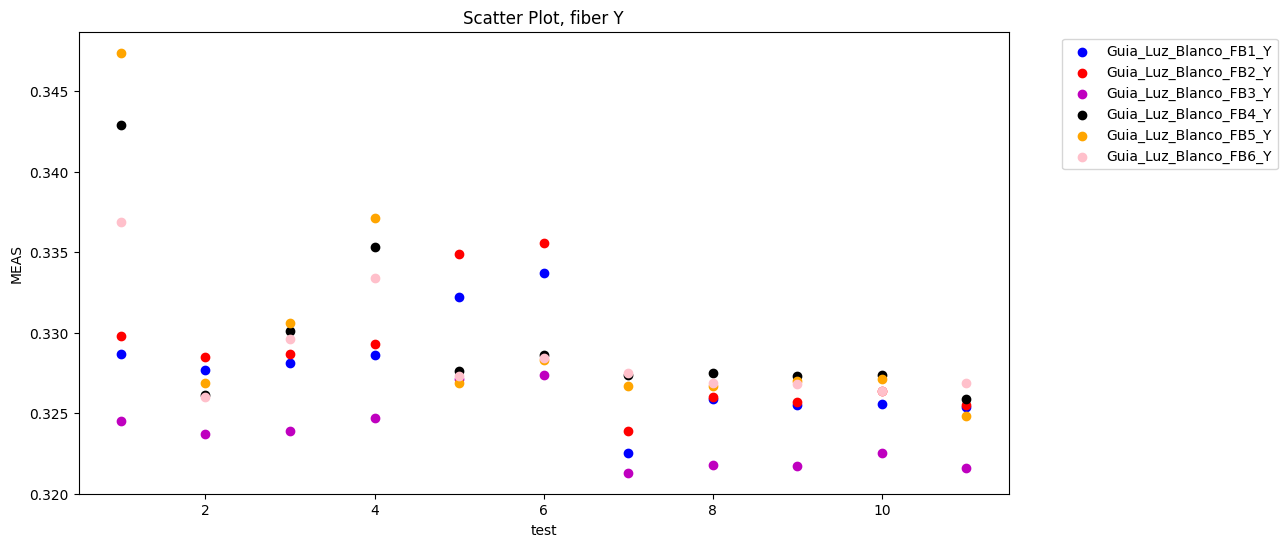

In [7]:
##Visualizations
plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [8]:
##Descriptive statistics
RESUME = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns.
RESUME_format = rename_index(RESUME)
display(RESUME_format)

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,11.0,0.327627,0.003209,0.3225,0.32555,0.3277,0.32865,0.3337
Guia_Luz_Blanco_FB1_Y,11.0,0.349818,0.002702,0.3457,0.34785,0.3500,0.35105,0.3546
Guia_Luz_Blanco_FB2_X,11.0,0.328573,0.003773,0.3239,0.32585,0.3285,0.32955,0.3356
Guia_Luz_Blanco_FB2_Y,11.0,0.350536,0.003302,0.3462,0.34800,0.3510,0.35180,0.3562
Guia_Luz_Blanco_FB3_X,11.0,0.323655,0.002148,0.3213,0.32175,0.3237,0.32460,0.3274
Guia_Luz_Blanco_FB3_Y,11.0,0.345136,0.001985,0.3429,0.34330,0.3453,0.34635,0.3483
Guia_Luz_Blanco_FB4_X,11.0,0.329645,0.005098,0.3259,0.32735,0.3275,0.32935,0.3429
Guia_Luz_Blanco_FB4_Y,11.0,0.352491,0.004352,0.3494,0.35040,0.3505,0.35235,0.3639
Guia_Luz_Blanco_FB5_X,11.0,0.329955,0.006647,0.3248,0.32680,0.3270,0.32945,0.3474
Guia_Luz_Blanco_FB5_Y,11.0,0.352518,0.005428,0.3487,0.34975,0.3500,0.35235,0.3666


Analysis of faulty fibers

In [9]:
##Analysis of faulty fibers
std = pd.DataFrame(RESUME_format['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Add an absolute number for quick identification
largest = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filter the 5 largest values
largest

,std,Fiber number
Guia_Luz_Blanco_FB5_X,0.006647,9
Guia_Luz_Blanco_FB5_Y,0.005428,10
Guia_Luz_Blanco_FB4_X,0.005098,7
Guia_Luz_Blanco_FB4_Y,0.004352,8
Guia_Luz_Blanco_FB2_X,0.003773,3


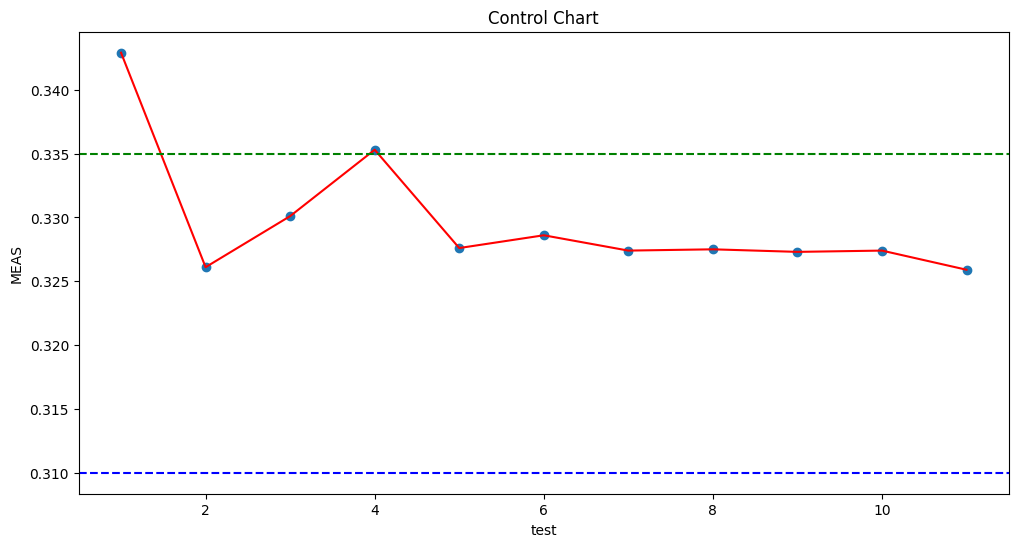

In [16]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_control_chart(MEAS_format, title='Control Chart', xlabel='test', ylabel='MEAS', LIMITS=LIMITS, fiber=fiber_selection.value, yrange=yrange)

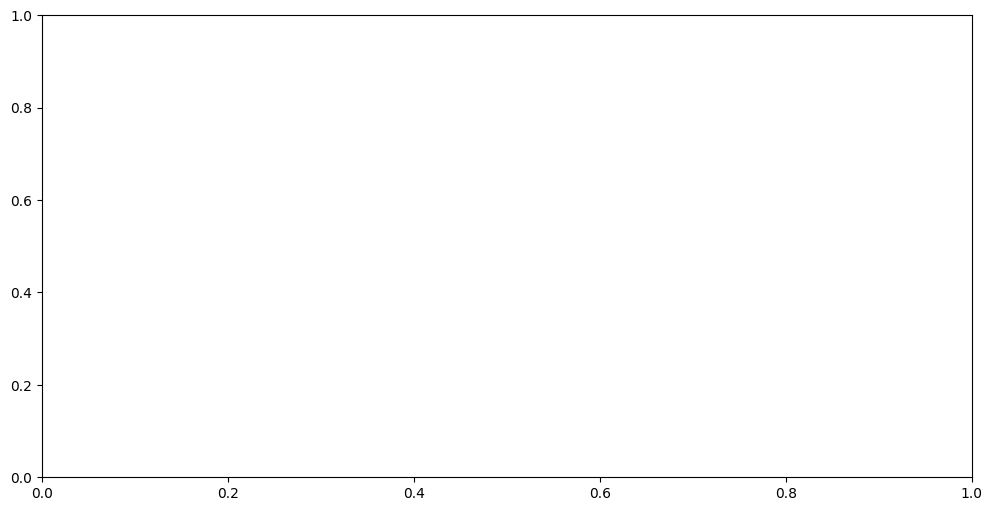

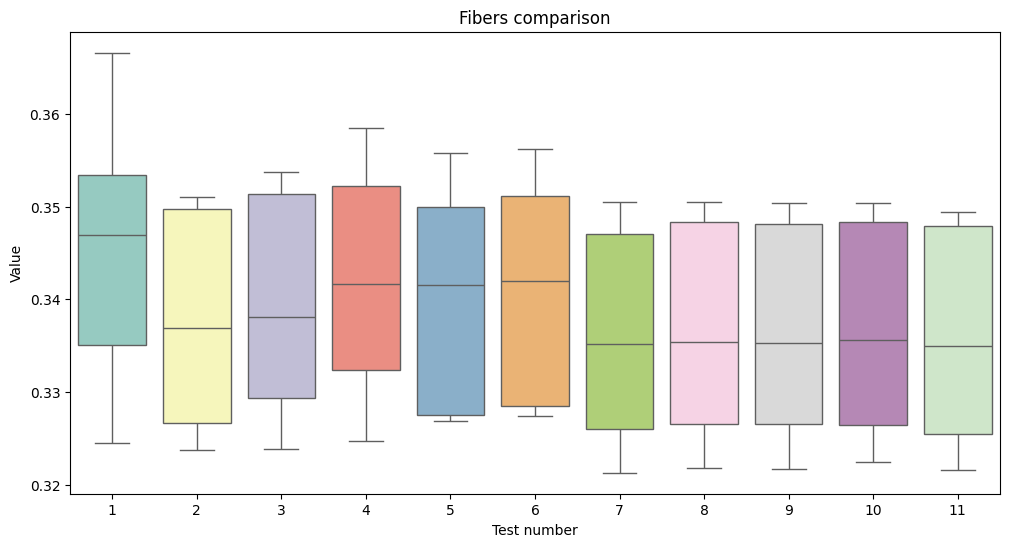

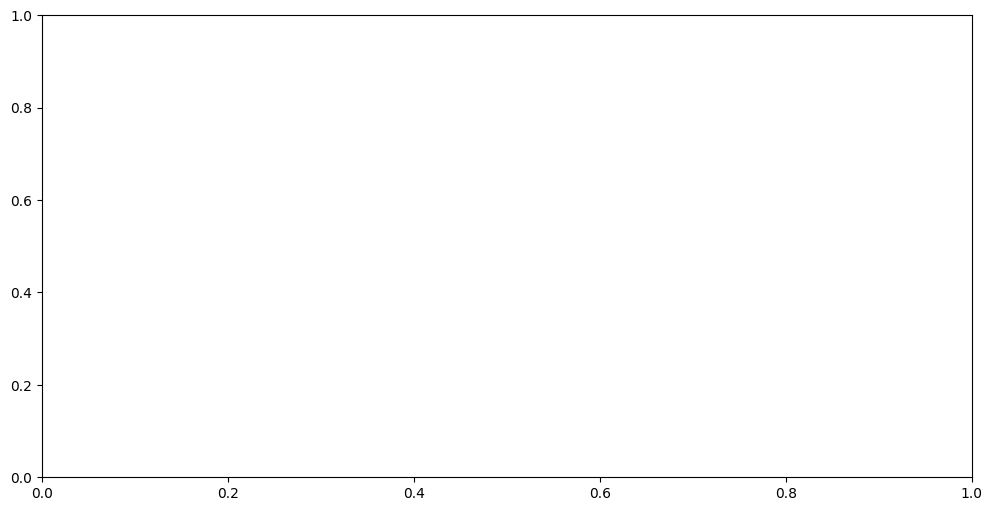

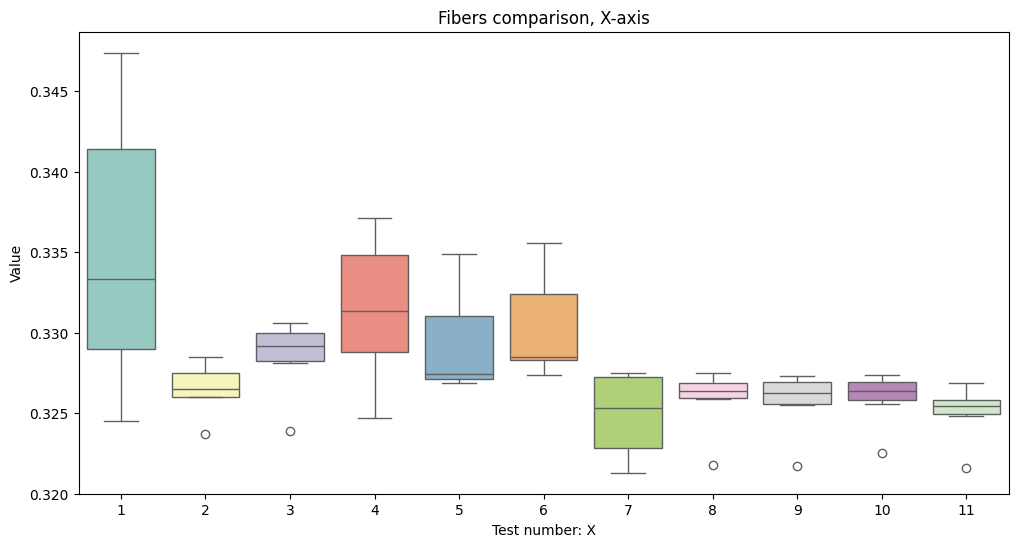

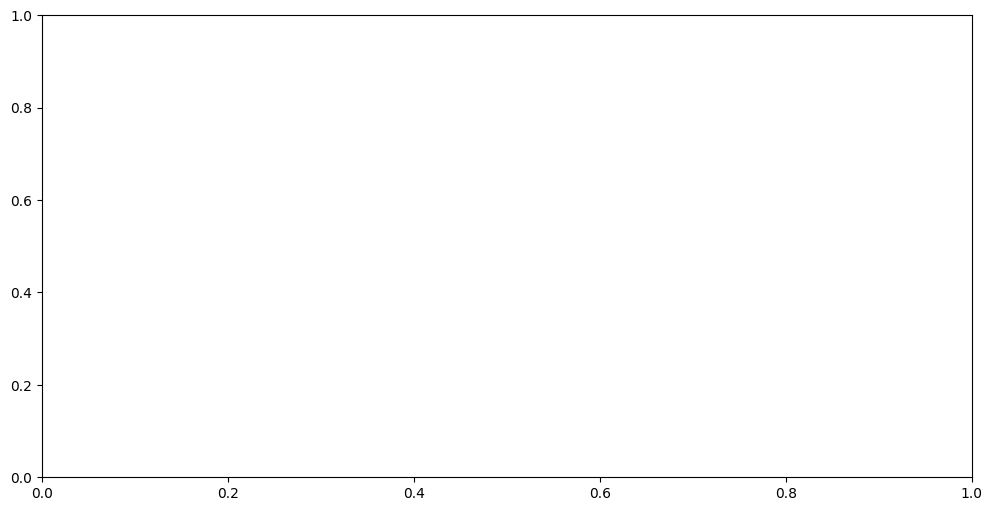

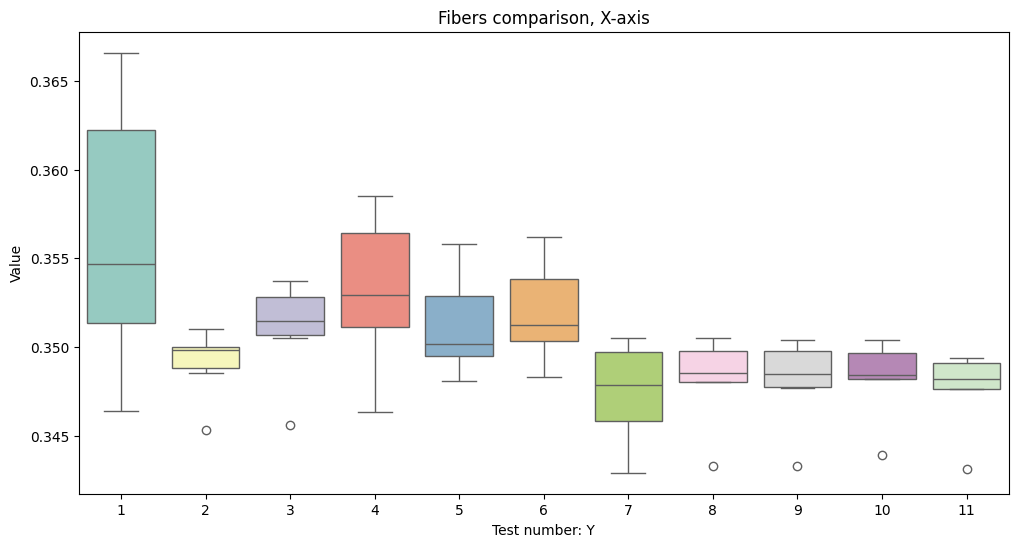

In [13]:
#Subgroups visualizations
plot_boxplot(MEAS_format, title="Fibers comparison", xlabel="Test number", ylabel="Value", filter=None)
plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="X")
plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="Y")

In [12]:
plot_boxplot(MEAS_format.transpose(), title="Fibers comparison", xlabel="Fibers group: ", ylabel="Value", filter="X", lenses_per_nest=FIXTURE_DATA.iloc["lenses per nest"])
plot_boxplot(MEAS_format.transpose(), title="Fibers comparison", xlabel="Fibers group: ", ylabel="Value", filter="Y", lenses_per_nest=glob.lenses_per_nest)

TypeError: Cannot index by location index with a non-integer key